In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
train=pd.read_csv("Train_SU63ISt.csv")
test=pd.read_csv("Test_0qrQsBZ.csv")

In [4]:
train_org=train.copy()
test_org=test.copy()

In [5]:
train.columns,test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [6]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [7]:
train.shape, test.shape

((18288, 3), (5112, 2))

In [8]:
train['Datetime']=pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
test['Datetime']=pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
test_org['Datetime']=pd.to_datetime(test_org.Datetime,format='%d-%m-%Y %H:%M')
train_org['Datetime']=pd.to_datetime(train_org.Datetime,format='%d-%m-%Y %H:%M')

In [9]:
for i in (train,test,test_org,train_org):
    i['year']=i.Datetime.dt.year
    i['month']=i.Datetime.dt.month
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour

In [10]:
train['day of week']=train['Datetime'].dt.dayofweek
temp=train['Datetime']

In [11]:
def applyer(row):
    if row.dayofweek==5 or row.dayofweek==6:
        return 1
    else:
        return 0
temp2=train['Datetime'].apply(applyer)
train['weekend']=temp2

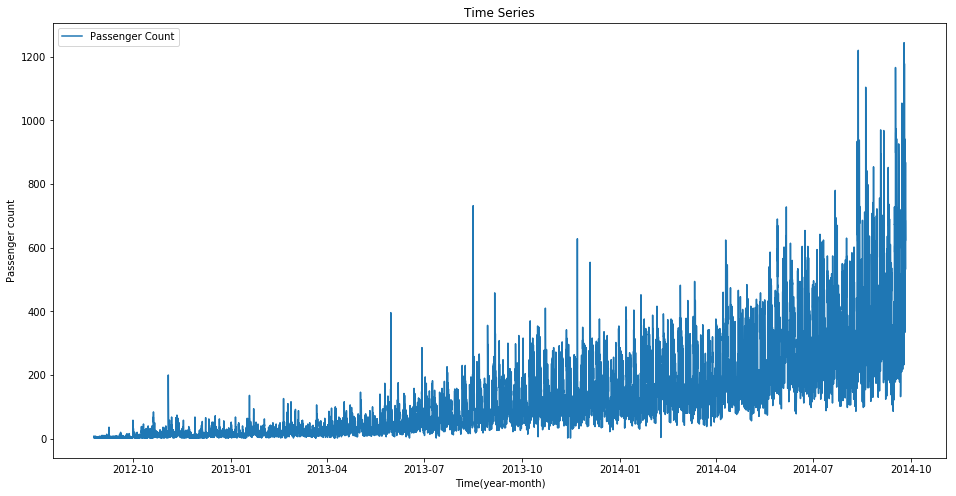

In [12]:
train.index=train['Datetime']
df=train.drop('ID',1)
ts=df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts,label='Passenger Count')
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')

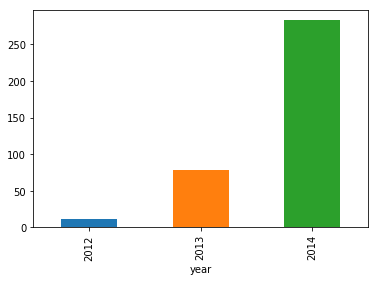

In [13]:
train.groupby('year')['Count'].mean().plot.bar()

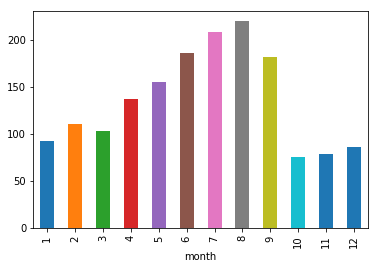

In [14]:
train.groupby('month')['Count'].mean().plot.bar()

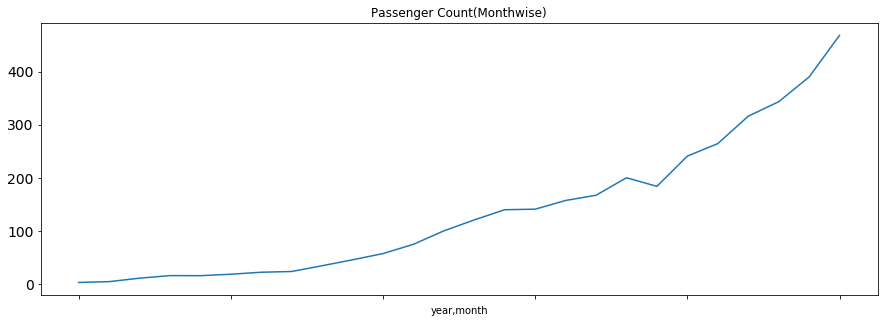

In [15]:
temp=train.groupby(['year','month'])['Count'].mean()
temp.plot(figsize=(15,5),title='Passenger Count(Monthwise)',fontsize=14)

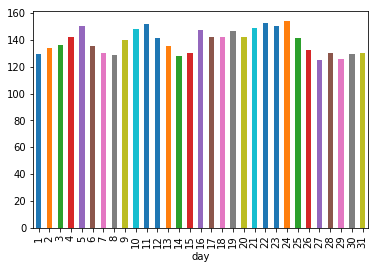

In [16]:
train.groupby('day')['Count'].mean().plot.bar()

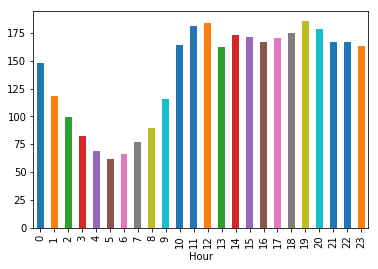

In [17]:
train.groupby('Hour')['Count'].mean().plot.bar()

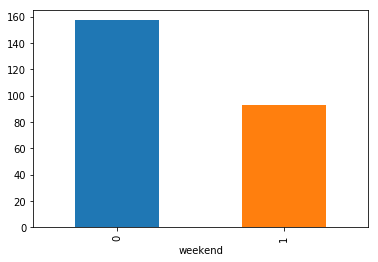

In [18]:
train.groupby('weekend')['Count'].mean().plot.bar()

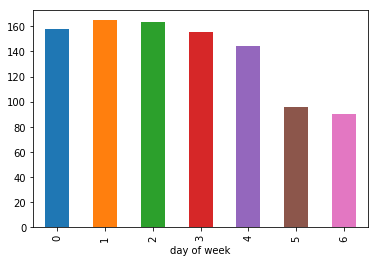

In [19]:
train.groupby('day of week')['Count'].mean().plot.bar()

In [20]:
train=train.drop('ID',1)

In [21]:
train.Timestamp=pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index=train.Timestamp

hourly=train.resample('H').mean()

daily=train.resample('D').mean()

weekly=train.resample('W').mean()

monthly=train.resample('M').mean()

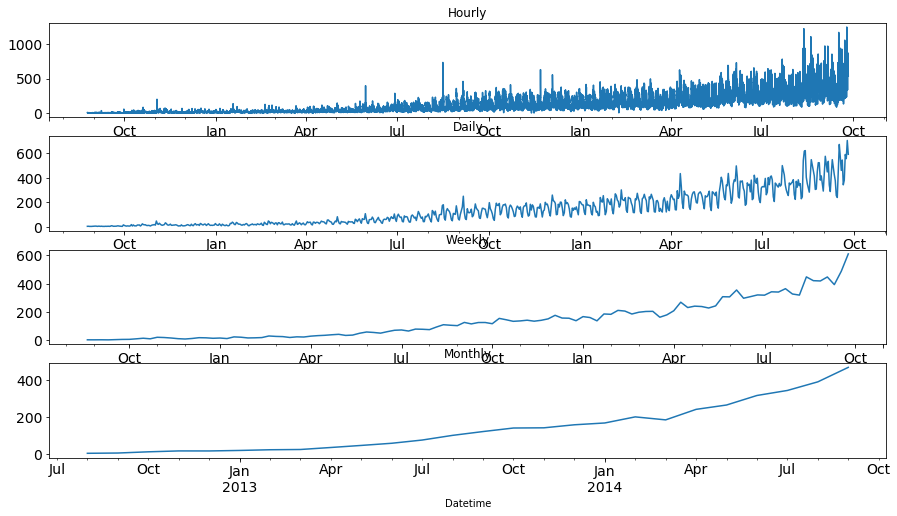

In [22]:
fig,axs=plt.subplots(4,1)

hourly.Count.plot(figsize=(15,8),title='Hourly',fontsize=14,ax=axs[0])

daily.Count.plot(figsize=(15,8),title='Daily',fontsize=14,ax=axs[1])

weekly.Count.plot(figsize=(15,8),title='Weekly',fontsize=14,ax=axs[2])

monthly.Count.plot(figsize=(15,8),title='Monthly',fontsize=14,ax=axs[3])

plt.show()

In [23]:
test.Timestamp=pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
test.index=test.Timestamp

test=test.resample('D').mean()

train.Timestamp=pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index=train.Timestamp

train=train.resample('D').mean()

In [24]:
Train=train.ix['2012-08-25':'2014-06-24']
valid=train.ix['2014-06-25':'2014-09-25']

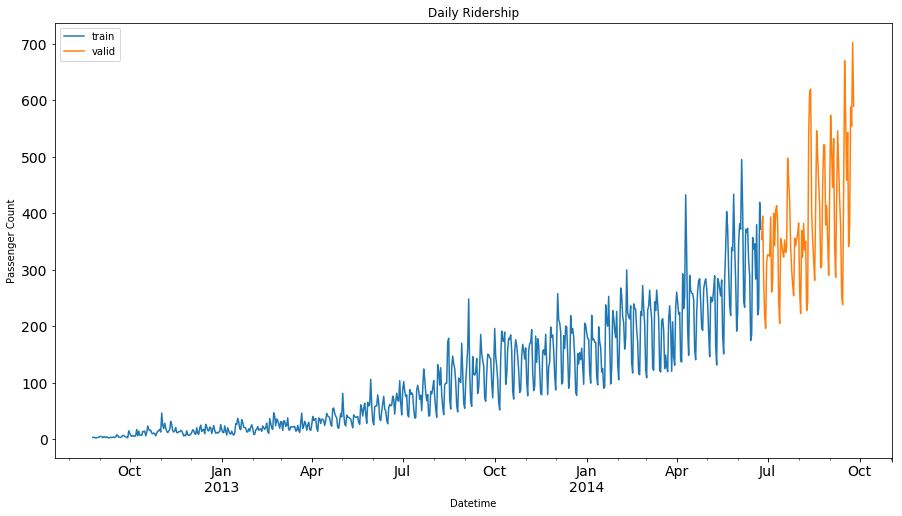

In [25]:
Train.Count.plot(figsize=(15,8),title='Daily Ridership',fontsize=14,label='train')
valid.Count.plot(figsize=(15,8),title='Daily Ridership',fontsize=14,label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger Count")
plt.legend(loc='best')
plt.show()

## Naive Approach

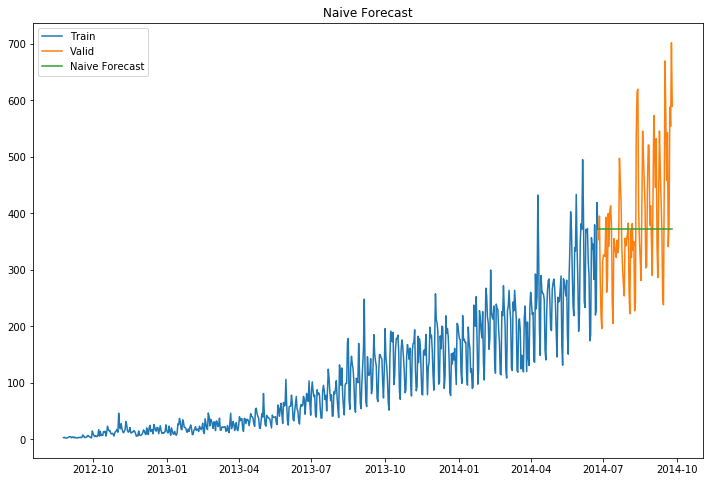

In [26]:
dd=np.asarray(Train.Count)
y_hat=valid.copy()
y_hat['naive']=dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(Train.index,Train['Count'],label='Train')
plt.plot(valid.index,valid['Count'],label='Valid')
plt.plot(y_hat.index,y_hat['naive'],label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms=sqrt(mean_squared_error(valid.Count,y_hat.naive))
print(rms)

111.79050467496724


## Moving Average

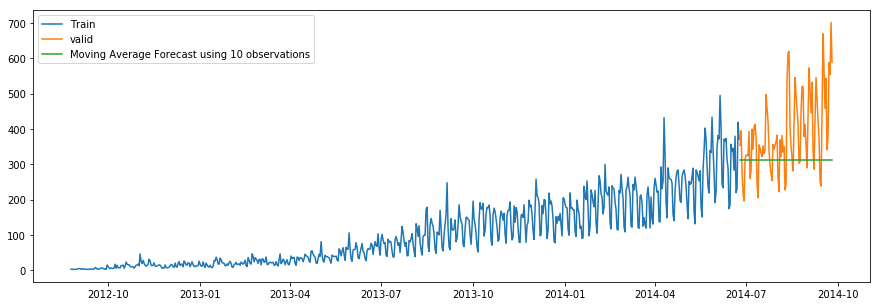

In [37]:
y_hat_avg=valid.copy()
y_hat_avg['moving_avg_forecast']=Train['Count'].rolling(10).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='valid')
plt.plot(y_hat_avg['moving_avg_forecast'],label='Moving Average Forecast using 10 observations')
plt.legend(loc='best')
plt.show()

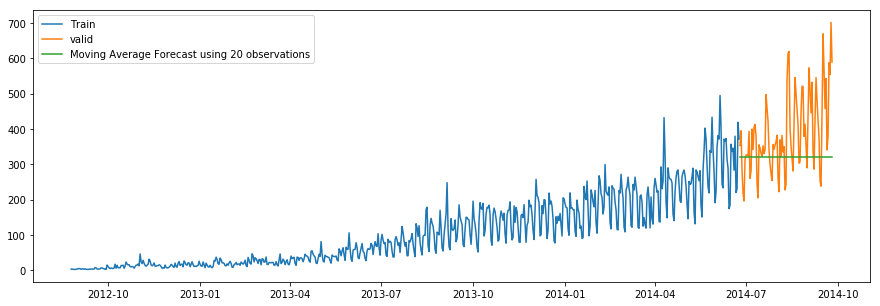

In [38]:
y_hat_avg=valid.copy()
y_hat_avg['moving_avg_forecast']=Train['Count'].rolling(20).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='valid')
plt.plot(y_hat_avg['moving_avg_forecast'],label='Moving Average Forecast using 20 observations')
plt.legend(loc='best')
plt.show()

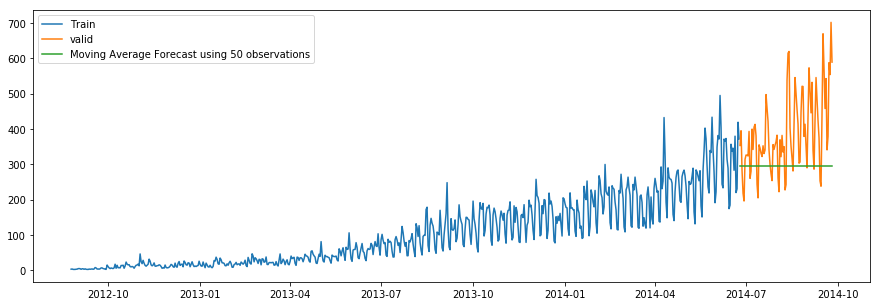

In [39]:
y_hat_avg=valid.copy()
y_hat_avg['moving_avg_forecast']=Train['Count'].rolling(50).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='valid')
plt.plot(y_hat_avg['moving_avg_forecast'],label='Moving Average Forecast using 50 observations')
plt.legend(loc='best')
plt.show()

In [40]:
rms=sqrt(mean_squared_error(valid.Count,y_hat_avg.moving_avg_forecast))
print(rms)

144.19175679986802


## Simple Exponential Smoothing

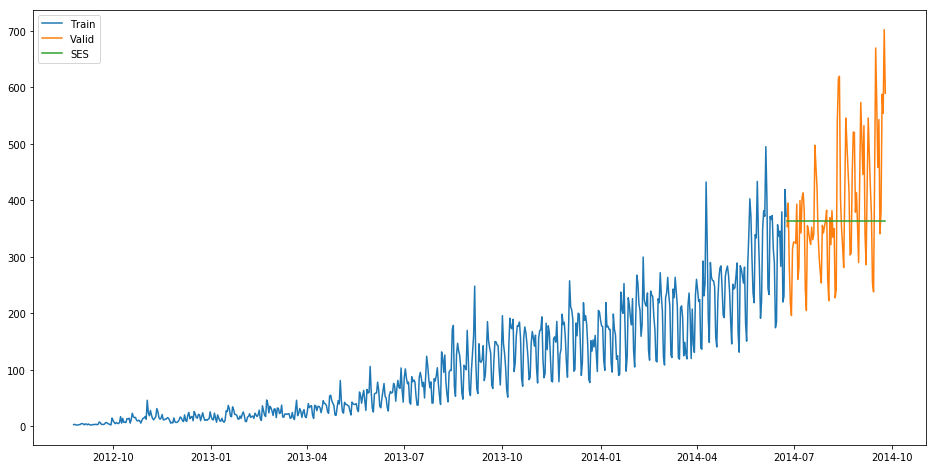

In [42]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing,Holt
y_hat_avg=valid.copy()
fit2=SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES']=fit2.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='Valid')
plt.plot(y_hat_avg['SES'],label='SES')
plt.legend(loc='best')
plt.show()

In [43]:
rms=sqrt(mean_squared_error(valid.Count,y_hat_avg.SES))
print(rms)

113.43708111884514


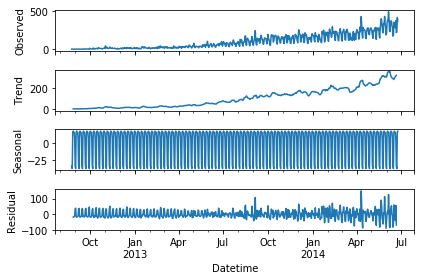

In [45]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result=sm.tsa.stattools.adfuller(train.Count)
plt.show()

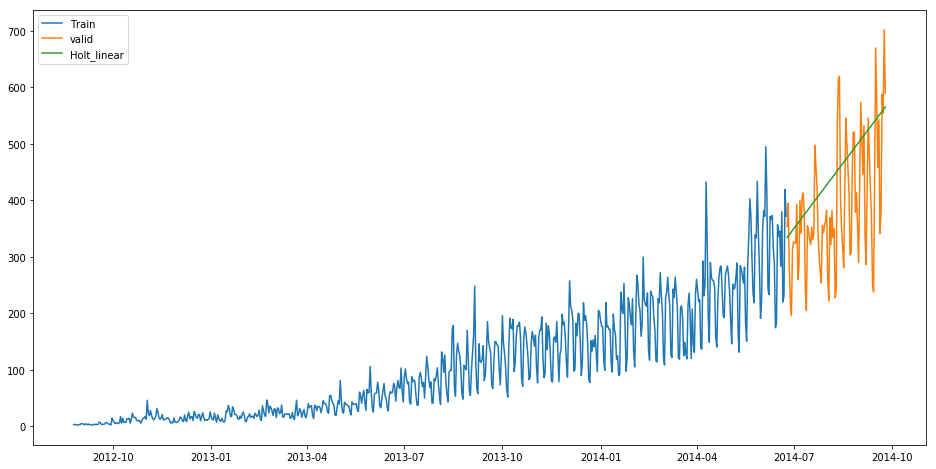

In [46]:
y_hat_avg=valid.copy()
fit1=Holt(np.asarray(Train['Count'])).fit(smoothing_level=0.3,smoothing_slope=0.1)
y_hat_avg['Holt_linear']=fit1.forecast(len(valid))

plt.figure(figsize=(16,8))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='valid')
plt.plot(y_hat_avg['Holt_linear'],label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [48]:
rms=sqrt(mean_squared_error(valid.Count,y_hat_avg.Holt_linear))
print(rms)

112.94278345314041


In [50]:
submission=pd.read_csv("Sample_Submission_QChS6C3.csv")

In [51]:
predict=fit1.forecast(len(test))

In [52]:
test['prediction']=predict

In [63]:
#calculating the hourly ratio of count
train_org['ratio']=train_org['Count']/train_org['Count'].sum()

#grouping the hourly ratio
temp=train_org.groupby(['Hour'])['ratio'].sum()

#groupby to csv format
pd.DataFrame(temp,columns=['Hour','ratio']).to_csv('GROUPby.csv')

temp2=pd.read_csv("GROUPby.csv")
temp2=temp2.drop('Hour.1',1)

#merge test and test_original on day,month and year
merge=pd.merge(test,test_org,on=('day','month','year'),how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['year','month','Datetime','Hour_x','Hour_y'],axis=1)

#predicting by merging merge and temp2
prediction=pd.merge(merge,temp2,on='Hour',how='left')

#converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y']

In [64]:
Sample_Submission_QChS6c3=prediction.drop(['ID_x','day','ID_y','prediction','Hour','ratio'],axis=1)

#converting the final submission to csv format
pd.DataFrame(Sample_Submission_QChS6c3,columns=['ID','Count']).to_csv('Holt linear.csv')

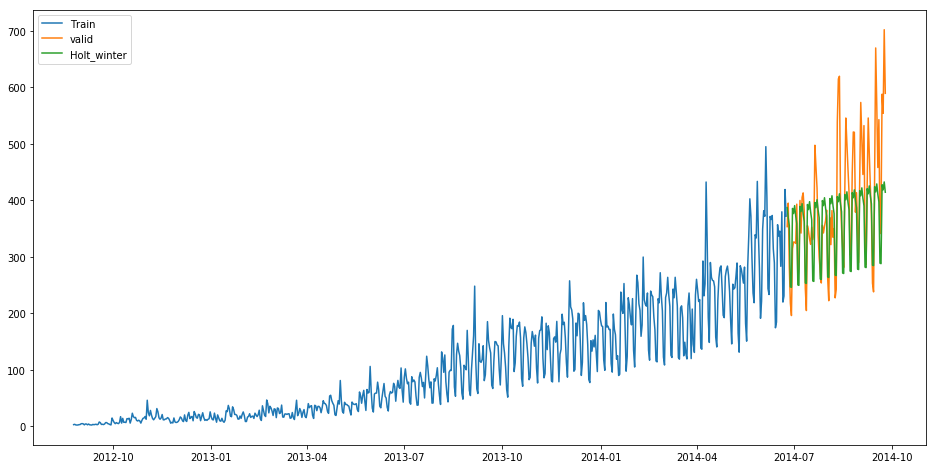

In [65]:
y_hat_avg=valid.copy()
fit1=ExponentialSmoothing(np.asarray(Train['Count']),seasonal_periods=7,trend='add',seasonal='add',).fit()
y_hat_avg['Holt_winter']=fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='valid')
plt.plot(y_hat_avg['Holt_winter'],label='Holt_winter')
plt.legend(loc='best')
plt.show()

In [69]:
rms=sqrt(mean_squared_error(valid.Count,y_hat_avg.Holt_winter))
print(rms)

82.37467736825413


In [70]:
predict=fit1.forecast(len(test))

In [71]:
test['prediction']=predict

In [72]:
#merge test and test original on day,month and year
merge=pd.merge(test,test_org,on=('day','month','year'),how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['year','month','Datetime','Hour_x','Hour_y'],axis=1)

#predicting by merging merge and temp2
prediction=pd.merge(merge,temp2,on='Hour',how='left')

#converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24

In [73]:
prediction['ID']=prediction['ID_y']
Sample_Submission_QChS6c3=prediction.drop(['day','Hour','ratio','prediction','ID_x','ID_y'],axis=1)

#converting the final submisssion to csv format
pd.DataFrame(submission,columns=['ID','Count']).to_csv('Holt winters.csv')

In [74]:
Sample_Submission_QChS6c3.head(19)

,Count,ID
0,411.716346,18288
1,328.571184,18289
2,278.072424,18290
3,229.761310,18291
4,193.390789,18292
5,173.116656,18293
6,186.147414,18294
7,215.881833,18295
8,248.601400,18296
9,321.247327,18297


In [87]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=24) # 24 hours on each day
    rolstd = pd.rolling_std(timeseries, window=24)
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [85]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [86]:
test_stationarity(train_org['Count'])

AttributeError: module 'pandas' has no attribute 'rolling_mean'